In [1]:
# ----------------------- #
# Grabbing sources script #
# ----------------------- #
'''
Script to run galaxy source extraction for
deblended SCARLET sources of galaxies. 
Designed to run using as many CPU's as
requested.
'''

# packages and libraries
import scarlet
from lsst.afw.image import MultibandExposure
from lsst.geom import Box2I, Point2I, Extent2I
import lsst.meas.extensions.scarlet as mes
from lsst.daf.butler import Butler
#from tqdm.notebook import tqdm # comment out for script version of code
from tqdm.auto import tqdm # comment out for script version of code
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from multiprocessing import Process
from multiprocessing import Pool
import os
from time import sleep
import psutil
import pandas as pd

# ---------------------------------------- #
# now grab the sources and store as arrays #
# ---------------------------------------- #
# 3 tracts 9617, 9697, 9813
# 81 patches per tract

REPO           = "/projects/HSC/repo/main"                     # Subaru Huper-Suprime Cam catalogue
COLL           = "HSC/runs/RC2/w_2022_40/DM-36151"             # current data release
#butler         = Butler(REPO, collections=[COLL])              # create THE BUTLER

    
def collect_src( patch ):
    
    child_end      = 15                                         # go up to child_end numbers of blended components
    #n_child        = list(range(1,child_end))                   # number of deblended children to use
    n_child = 5
    num_child      = 1 #len(n_child)                               # number of blended children vector elements
    box_shapes     = []                                         # initialise storage array
    skip_count     = 0                                          # initialise source count
    
    # tract 3 9813
    if (patch > 160):
        tract = 9813
        patch_tmp = patch - 161

    
    # tract 2 9697
    if (patch > 80) and (patch < 161):
        tract = 9697
        patch_tmp = patch - 81
        
    # tract 1 9615    
    if (patch < 81):
        tract = 9615
        patch_tmp = patch
        
    patch = patch_tmp
    
    # for TESTING
    process = multiprocessing.current_process()
    # get the pid
    pid = process.pid
    #print(f'\n extracting galaxies in HSC patch {patch} of tract {tract} on processor ID {pid}')
    butler = Butler(REPO, collections=[COLL])              # create THE BUTLER
    catalog = butler.get("deepCoadd_deblendedCatalog", tract=tract, patch=patch)
    modelData = butler.get("deepCoadd_scarletModelData", tract=tract, patch=patch)

    # grab the PSF per patch
    observedPSF = [butler.get("deepCoadd_calexp.psf",tract=tract, patch=patch, band=band)
                  for band in modelData.bands]
    
    
    # loop over full catalogue
    desc = 'extracting scene tract ' + str(tract) + ' patch ' + str(patch)
    for k in tqdm(range( num_child ),desc = desc):
            

        # grab all instances of  exactly n_child deblended children
        parent = catalog[catalog["deblend_nChild"]== n_child][:]
        src_length = 1 #len( parent )
        print(f'source number: {src_length}')

        for m in range(src_length):              
            
            #try:
                                
                parent_tmp = parent[m]
                parent_ID = parent_tmp.getId()
                #print(f'parent id: {parent_ID}')
                blendData = modelData.blends[parent_tmp.getId()]
                bbox = Box2I(Point2I(*blendData.xy0), Extent2I(*blendData.extent))
                
                nBands = len(modelData.bands)
                blend = mes.io.dataToScarlet(blendData, nBands=nBands)
                
                # get bounding box of full scene
                footprint = parent_tmp.getFootprint().getBBox().getDimensions()
                box_x = footprint.getX()
                box_y = footprint.getY()
                    
                # grab PSFs
                psf_g = observedPSF[0].computeImage().getArray()
                psf_i = observedPSF[1].computeImage().getArray()
                psf_r = observedPSF[2].computeImage().getArray()
                psf_y = observedPSF[3].computeImage().getArray()
                psf_z = observedPSF[4].computeImage().getArray()
                
                for l in range(n_child):
                    
                    # sepcify single source
                    model = blend.components[l]
                    sources = blend.sources[l]
                    center = sources.center
                    model_bands = sources.get_model()
                    
                    
                    # get images per band
                    g_band = model_bands[0]
                    i_band = model_bands[1]
                    r_band = model_bands[2]
                    y_band = model_bands[3]
                    z_band = model_bands[4]
                    
                    # get variances
                    var_g = g_band.var()
                    var_i = i_band.var()
                    var_r = r_band.var()
                    var_y = y_band.var()
                    var_z = z_band.var()
                    

                    # create dictionary
                    src_row = {
                               'parent_ID' : [parent_ID], 
                               'object_num' : [l],
                               'box_x' : [box_x],
                               'box_y' : [box_y],
                               'tract' : [tract],
                               'patch' : [patch],
                               'box_sz': [g_band.shape[1]],
                               'loc'   : [center],
                               'g'     : [g_band],
                               'i'     : [i_band],
                               'r'     : [r_band],
                               'y'     : [y_band],
                               'z'     : [z_band],
                               'PSF_g' : [psf_g], 
                               'PSF_i' : [psf_i], 
                               'PSF_r' : [psf_r], 
                               'PSF_y' : [psf_y], 
                               'PSF_z' : [psf_z],
                               'var_g' : [var_g], 
                               'var_i' : [var_i], 
                               'var_r' : [var_r], 
                               'var_y' : [var_y], 
                               'var_z' : [var_z],
                               }
                    
                    cols = ['parent_ID','object_num', 'box_x', 
                            'box_y', 'tract','patch',
                            'box_sz','loc','g','i','r',
                            'y','z','PSF_g', 'PSF_i', 
                            'PSF_r', 'PSF_y', 'PSF_z',
                            'var_g','var_i','var_r', 'var_y', 'var_z']
                    
                    if l == 0:
                        df = pd.DataFrame(src_row , columns = cols)
                    
                    else:
                        df_cur = pd.DataFrame(src_row , columns = cols)
                        df = pd.concat([df, df_cur], ignore_index = True)
                            
                
            #except:
            #    skip_count += 1
                        
                
    # save the data as a pickled pandas df
    df.to_pickle("data_test.pkl")
    print('data saved')
                


In [2]:
    
# ------------------ #
# collect scene data #
# ------------------ #

# testing on a single patch
#collect_src(12)
collect_src(20)
#collect_src(220)


'''
print('------------------------')
print('begin source extraction')
print('------------------------')
for i in range(15):
    try:
        collect_src(230 + i)
    except:
        print('skipped')
    print('------------------------')
    print(f'complete patch {i}')
    print('------------------------')
'''

extracting scene tract 9615 patch 20:   0%|          | 0/1 [00:00<?, ?it/s]

source number: 1
data saved


/tmp/ipykernel_198339/1470187006.py:111: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psf_g = observedPSF[0].computeImage().getArray()
/tmp/ipykernel_198339/1470187006.py:112: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psf_i = observedPSF[1].computeImage().getArray()
/tmp/ipykernel_198339/1470187006.py:113: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psf_r = observedPSF[2].computeImage().getArray()
/tmp/ipykernel_198339/1470187006.py:114: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psf_y = observedPSF[3].computeImage().getArray()
/tmp/ipykernel_198339/1470187006.py:115: FutureWarning: Default position

"\nprint('------------------------')\nprint('begin source extraction')\nprint('------------------------')\nfor i in range(15):\n    try:\n        collect_src(230 + i)\n    except:\n        print('skipped')\n    print('------------------------')\n    print(f'complete patch {i}')\n    print('------------------------')\n"

box size is: 
0    51
1    31
2    31
3    31
4    31
Name: box_sz, dtype: int64
centers: 
0    (19, 25)
1     (14, 6)
2     (6, 41)
3     (6, 30)
4    (27, 18)
Name: loc, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   parent_ID   5 non-null      int64  
 1   object_num  5 non-null      int64  
 2   box_x       5 non-null      int64  
 3   box_y       5 non-null      int64  
 4   tract       5 non-null      int64  
 5   patch       5 non-null      int64  
 6   box_sz      5 non-null      int64  
 7   loc         5 non-null      object 
 8   g           5 non-null      object 
 9   i           5 non-null      object 
 10  r           5 non-null      object 
 11  y           5 non-null      object 
 12  z           5 non-null      object 
 13  PSF_g       5 non-null      object 
 14  PSF_i       5 non-null      object 
 15  PSF_r      

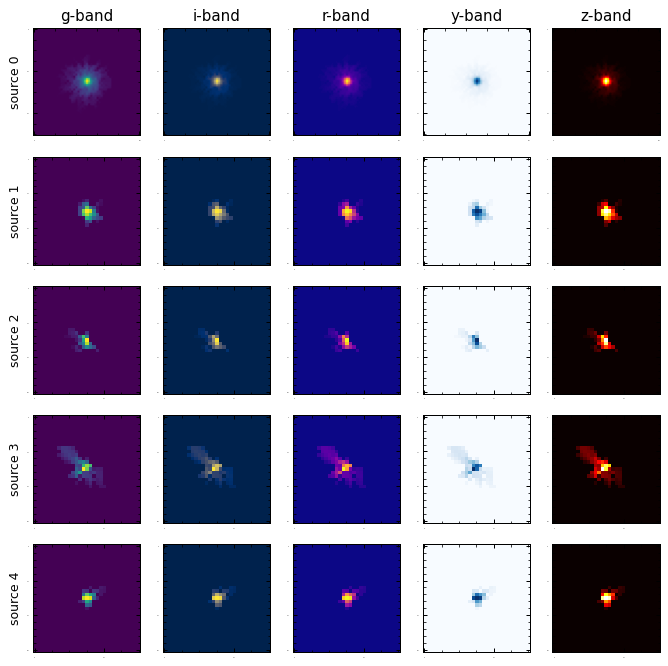

In [3]:
df = pd.read_pickle("data_test.pkl")

print('box size is: ')
print(df['box_sz'])

print('centers: ')
print(df['loc'])

print(df.info())

# plot things
import matplotlib as mpl
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

fig = plt.figure(figsize=(9, 9), dpi = 90)
n_child = 5

for i in range(n_child):
    plt.subplot(n_child,5,i*5 + 1)
    plt.imshow(df['g'][i])
    if(i == 0): plt.title('g-band')
    name = 'source ' + str(df['object_num'][i])
    plt.ylabel(name)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 2)
    plt.imshow(df['i'][i], cmap = 'cividis')
    if(i == 0): plt.title('i-band')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 3)
    plt.imshow(df['r'][i], cmap = 'plasma')
    if(i == 0): plt.title('r-band')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 4)
    plt.imshow(df['y'][i], cmap = 'Blues')
    if(i == 0): plt.title('y-band')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 5)
    plt.imshow(df['z'][i], cmap = 'hot')
    if(i == 0): plt.title('z-band')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)
    
plt.show()


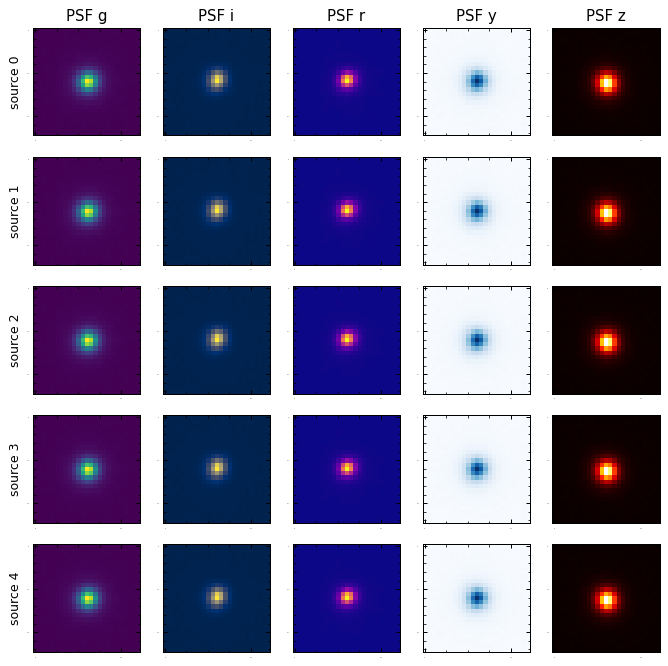

In [4]:
fig = plt.figure(figsize=(9, 9), dpi = 90)
n_child = 5
for i in range(n_child):
    plt.subplot(n_child,5,i*5 + 1)
    plt.imshow(df['PSF_g'][i])
    if(i == 0): plt.title('PSF g')
    name = 'source ' + str(df['object_num'][i])
    plt.ylabel(name)
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 2)
    plt.imshow(df['PSF_i'][i], cmap = 'cividis')
    if(i == 0): plt.title('PSF i')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 3)
    plt.imshow(df['PSF_r'][i], cmap = 'plasma')
    if(i == 0): plt.title('PSF r')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 4)
    plt.imshow(df['PSF_y'][i], cmap = 'Blues')
    if(i == 0): plt.title('PSF y')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)

    plt.subplot(n_child,5,i*5 + 5)
    plt.imshow(df['PSF_z'][i], cmap = 'hot')
    if(i == 0): plt.title('PSF z')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=0)
    
plt.show()

In [5]:
import lsst.meas.extensions.scarlet as mes

tract = df['tract'][0]
patch = df['patch'][0]

butler = Butler(REPO, collections=[COLL])              # create THE BUTLER
catalog = butler.get("deepCoadd_deblendedCatalog", tract=tract, patch=patch)
modelData = butler.get("deepCoadd_scarletModelData", tract=tract, patch=patch)

# Select the first record with exactly 7 deblended children
parent = catalog[catalog["deblend_nChild"]== n_child][0]
# Load the PSF for the observation in each band
observedPsfs = [
    butler.get("deepCoadd_calexp.psf", tract=tract, patch=patch, band=band)
    for band in modelData.bands
]

# Extract the scarlet LiteBlend from the ScarletModelData
blend = mes.io.multibandDataToScarlet(
    modelData=modelData,
    blendId=parent.getId(),
    observedPsfs=observedPsfs
)



from lsst.afw.image import MultibandExposure
from lsst.geom import Box2I, Point2I, Extent2I
# Extract the bounding box for the blend
blendData = modelData.blends[parent.getId()]
bbox = Box2I(Point2I(*blendData.xy0), Extent2I(*blendData.extent))
# Load the Exposure in each band
mExposure = MultibandExposure.fromButler(
    butler,
    modelData.bands,
    "deepCoadd_calexp",
    parameters={"bbox": bbox},
    tract=tract,
    patch=patch
)

# Extract the scarlet LiteBlend from the ScarletModelData
blend = mes.io.multibandDataToScarlet(
    modelData=modelData,
    blendId=parent.getId(),
    mExposure=mExposure,
    footprint=parent.getFootprint()
)

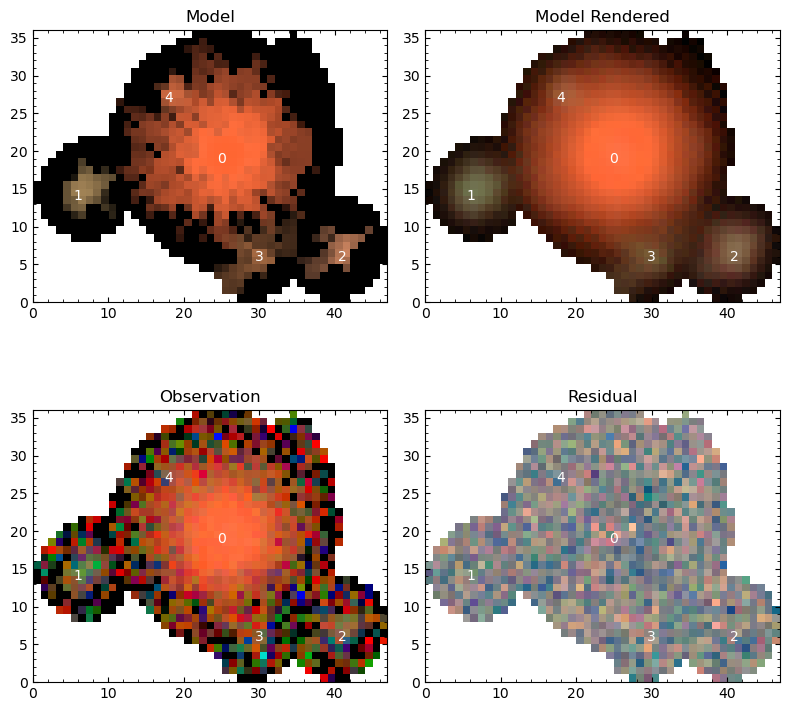

In [6]:
# Use the Lupton RGB sinh^-1 mapping to preserve colors
norm = scarlet.display.AsinhMapping(minimum=0, stretch=0.1, Q=10)
# Hide the narrow-band filter
channelMap = np.zeros((3, 6))
channelMap[:, 1:] = scarlet.display.channels_to_rgb(5)
channelMap

# Display the scene
scarlet.lite.display.show_scene(
    blend,
    norm=norm,
    show_model=True,
    show_rendered=True,
    show_observed=True,
    show_residual=True,
    linear=False,
    figsize=(8, 8),
)
plt.show()